In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import jax
import jax.numpy as jnp
import jax.random as jxr
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('gplds/')
import utils
from models import wGPLDS, WeightSpaceGaussianProcess
from models import ParamswGPLDS
from inference import fit_em

/Users/andrewaoun/Documents/PHD/Projects/GPLDS/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def window_raster(raster, window=60):
    n_trials, n_time_bins = raster.shape
    n_windows = n_time_bins / window 
    n_windows = int(n_windows)

    def _custom_nansum(arr):
        is_all_nan = jnp.all(jnp.isnan(arr), axis=1)
        nansum = jnp.nansum(arr, axis=1)
        nansum = jnp.where(is_all_nan, jnp.nan, nansum)
        return nansum

    windowed_raster = raster[:, :n_windows * window].reshape(n_trials, n_windows, window)

    windowed_raster = jax.vmap(_custom_nansum)(windowed_raster)
    mask = jnp.isnan(windowed_raster)
    mask = jnp.where(mask, 0, 1)

    return windowed_raster, mask

def window_constant_covariate(covariate, window=60):
    n_time_bins = covariate.shape[0]
    n_windows = n_time_bins / window
    n_windows = int(n_windows)
    
    windowed_covariate = covariate[:n_windows * window].reshape(n_windows, window)
    return jnp.nanmean(windowed_covariate, axis=1) 


In [3]:
# folder_path = r"/Users/andrewaoun/Documents/PHD/Projects/GPLDS/RNN/hidden_activity_bounds2"

# bin_window = 1

# p1_ramps = []
# p2_ramps = []
# for file in os.listdir(folder_path):
#     if file.endswith(".npy") and "Tout" in file and "ramp" in file:
#         file_path = os.path.join(folder_path, file)
#         data = jnp.load(file_path)
#         coh_level = file.split("C")[-1].split(".npy")[0].split("_")[0]
        
#         ramps = []
#         for i in range(data.shape[0]):
#             ramp = data[i]
#             ramp = window_constant_covariate(ramp, window=bin_window)
#             ramps.append(ramp)
#         ramps = jnp.stack(ramps, axis=0)

#         if 'p1' in file.lower():
#             p1_ramps.append(ramps)
#         elif 'p2' in file.lower():
#             p2_ramps.append(ramps)

# p1_ramps = jnp.concatenate(p1_ramps, axis=0)
# p2_ramps = jnp.concatenate(p2_ramps, axis=0)

# print(p1_ramps.shape, p2_ramps.shape)

In [4]:
folder_path = r"/Users/andrewaoun/Documents/PHD/Projects/GPLDS/RNN/hidden_activity_bounds2"

bin_window = 1

p1 = []
p2 = []
p1_coh = []
p2_coh = []
p1_psth = []
p2_psth = []
p2_coh_levels = []
p1_coh_levels = []
dirlist = sorted(os.listdir(folder_path))
# for file in os.listdir(folder_path):
for file in dirlist:
    if file.endswith(".npy") and "T" in file and "ramp" not in file:
        file_path = os.path.join(folder_path, file)
        data = jnp.load(file_path)
        coh_level = file.split("C")[-1].split(".npy")[0].split("_")[0]
        print(file, data.shape)
        coh_pulse = jnp.ones(data.shape[1]) * float(coh_level)
        trials = []
        coh_pulses = []
        for neuron in range(data.shape[-1]):
            if neuron == 0:
                coh_data = window_constant_covariate(coh_pulse, window=bin_window)
                coh_data = jnp.tile(coh_data, (data.shape[0], 1))
                coh_pulses.append(coh_data)
            if bin_window > 1:
                print('Binning with window size:', bin_window)
                trial_data, _ = window_raster(data[:,:,neuron], window=bin_window)
            else:
                trial_data = data[:,:,neuron]
            # trial_data = (trial_data - jnp.nanmean(trial_data, axis=1, keepdims=True)) / jnp.nanstd(trial_data, axis=1, keepdims=True)
            trials.append(trial_data)
        trials = jnp.stack(trials, axis=-1)
        coh_pulses = jnp.stack(coh_pulses, axis=-1)
        psth = jnp.nanmean(trials, axis=0)
        if "p1" in file.lower():
            p1.append(trials)
            p1_coh.append(coh_pulses)
            p1_psth.append(psth)
            p1_coh_levels.append(float(coh_level))
        else:
            assert "p2" in file.lower()
            p2.append(trials)
            p2_coh.append(coh_pulses)
            p2_psth.append(psth)
            p2_coh_levels.append(float(coh_level))
    

p1 = jnp.concatenate(p1, axis=0)
p2 = jnp.concatenate(p2, axis=0)

p1_coh = jnp.concatenate(p1_coh, axis=0)
p2_coh = jnp.concatenate(p2_coh, axis=0)

print('Bin window:', bin_window)

print(p1.shape)
print(p2.shape)

print(p1_coh.shape)
print(p2_coh.shape)

p1_psth = jnp.array(p1_psth)
p2_psth = jnp.array(p2_psth)

print(p1_psth.shape)
print(p2_psth.shape)

p1_coh_levels = jnp.array(p1_coh_levels)
p2_coh_levels = jnp.array(p2_coh_levels)

print(p1_coh_levels.shape)
print(p2_coh_levels.shape)


[xla_bridge.py][2025-01-07 15:47:04,866] INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[xla_bridge.py][2025-01-07 15:47:04,867] INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


P1_hidden_C-0.032_Tin.npy (53, 500, 30)
P1_hidden_C-0.032_Tout.npy (76, 500, 30)
P1_hidden_C-0.064_Tin.npy (66, 500, 30)
P1_hidden_C-0.064_Tout.npy (87, 500, 30)
P1_hidden_C-0.128_Tin.npy (53, 500, 30)
P1_hidden_C-0.128_Tout.npy (100, 500, 30)
P1_hidden_C-0.256_Tin.npy (21, 500, 30)
P1_hidden_C-0.256_Tout.npy (123, 500, 30)
P1_hidden_C-0.512_Tin.npy (3, 500, 30)
P1_hidden_C-0.512_Tout.npy (125, 500, 30)
P1_hidden_C0.032_Tin.npy (76, 500, 30)
P1_hidden_C0.032_Tout.npy (68, 500, 30)
P1_hidden_C0.064_Tin.npy (62, 500, 30)
P1_hidden_C0.064_Tout.npy (62, 500, 30)
P1_hidden_C0.0_Tin.npy (68, 500, 30)
P1_hidden_C0.0_Tout.npy (71, 500, 30)
P1_hidden_C0.128_Tin.npy (95, 500, 30)
P1_hidden_C0.128_Tout.npy (37, 500, 30)
P1_hidden_C0.256_Tin.npy (100, 500, 30)
P1_hidden_C0.256_Tout.npy (23, 500, 30)
P1_hidden_C0.512_Tin.npy (129, 500, 30)
P1_hidden_C0.512_Tout.npy (2, 500, 30)
P2_hidden_C-0.032_Tin.npy (53, 500, 60)
P2_hidden_C-0.032_Tout.npy (76, 500, 60)
P2_hidden_C-0.064_Tin.npy (66, 500, 60)
P

In [5]:
if len(p2_coh_levels) != 11:
    assert len(p2_coh_levels) == 22
    p2_coh_levels = p2_coh_levels[::2]
    print(p2_coh_levels)

[-0.032 -0.064 -0.128 -0.256 -0.512  0.032  0.064  0.     0.128  0.256
  0.512]


In [6]:
stop()

NameError: name 'stop' is not defined

In [ ]:
# fig = plt.figure(figsize=(8, 25))
# for i in range(p2_psth.shape[0]):
#     ax = plt.subplot(p2_psth.shape[0], 1, i+1)
#     ax.plot(p2_psth[i,:,:], color='black')
#     ax.set_title('Coherence: {}'.format(p2_coh_levels[i]))
# fig.tight_layout()
# plt.show()




In [7]:
U1 = p2_coh
U2 = jnp.arange(0,1,1/U1.shape[1])
U2 = jnp.tile(U2, (U1.shape[0], 1))
Y = p2
Y_mask = jnp.ones((Y.shape[0], Y.shape[1]))
print(Y.shape, Y_mask.shape, U1.shape)


coherence_indices = []
prev_coh = None
for trial_idx in range(U1.shape[0]):
    trial = U1[trial_idx].squeeze()
    trial_coh = jnp.nanmax(trial)
    trial_coh_arg = jnp.where(trial == trial_coh)[0][0]
    trial_coh = float(trial[trial_coh_arg])
    trial_coh = round(trial_coh, 3)
    if prev_coh != trial_coh:
        # coherence_indices.append(float(trial_coh))
        coherence_indices.append(trial_idx)

    prev_coh = trial_coh

print(coherence_indices)

assert len(coherence_indices) == len(p2_coh_levels)

(1500, 500, 60) (1500, 500) (1500, 500, 1)
[0, 129, 282, 435, 579, 707, 851, 975, 1114, 1246, 1369]


In [8]:
import jax.numpy as jnp

def gaussian_smooth_truncated(psth, sigma, truncate=4):
    n_trials, n_time_bins = psth.shape
    kernel_half_width = int(truncate * sigma + 0.5)
    kernel = jnp.exp(-0.5 * (jnp.arange(-kernel_half_width, kernel_half_width + 1) / sigma) ** 2)
    kernel = kernel / kernel.sum()

    smoothed_psth = jnp.zeros_like(psth)
    for i in range(n_trials):
        for t in range(n_time_bins):
            left = max(0, t - kernel_half_width)
            right = min(n_time_bins, t + kernel_half_width + 1)
            
            effective_kernel = kernel[kernel_half_width - (t - left): kernel_half_width + (right - t)]
            effective_kernel = effective_kernel / effective_kernel.sum()  # Normalize clipped kernel
            
            smoothed_psth = smoothed_psth.at[i, t].set(
                jnp.sum(psth[i, left:right] * effective_kernel)
            )
    return smoothed_psth.T



In [9]:
def preprocess_for_pca(Y, coherence_indices, sigma=20):
    psths = []
    for idx in range(len(coherence_indices)):
        if idx == len(coherence_indices) - 1:
            trials = Y[coherence_indices[idx]:]
        else:
            trials = Y[coherence_indices[idx]:coherence_indices[idx + 1]]
        psth = jnp.mean(trials, axis=0)
        psths.append(psth)
    psths = jnp.array(psths)
    n_conditions, n_timepoints, n_neurons = psths.shape
    psths_smooth = jnp.array([gaussian_smooth_truncated(psths[:,:,i], sigma) for i in range(n_neurons)]).T
    # print(psths_smooth.shape)
    psths_concat = jnp.concatenate(psths_smooth, axis=0)
    psths_zscored = (psths_concat - jnp.mean(psths_concat, axis=0, keepdims=True)) / jnp.std(psths_concat, axis=0, keepdims=True)
    # stop()
    # mean_psth = jnp.mean(psths, axis=0, keepdims=True) # mean across conditions
    # psths_detrended = psths - mean_psth
    # mean_activity = jnp.mean(psths_detrended, axis=(0, 1), keepdims=True) # mean across conditions and timepoints
    # std_activity = jnp.std(psths_detrended, axis=(0, 1), keepdims=True) # std across conditions and timepoints
    # psths_zscore = (psths_detrended - mean_activity) / std_activity    
    # n_conditions, n_timepoints, n_neurons = psths_detrended.shape
    # Y_reshaped = psths_detrended.reshape(n_conditions * n_timepoints, n_neurons)
    return psths_zscored, n_conditions, n_timepoints, psths, psths_smooth, sigma

from sklearn.decomposition import PCA
from scipy.ndimage import uniform_filter1d
from scipy.ndimage import gaussian_filter1d
    
def run_pca(Y, coherence_indices):
    Y_pca_input, n_conditions, n_timepoints, psths, psths_smooth, sigma = preprocess_for_pca(Y, coherence_indices)

    pca = PCA(n_components=2)
    Y_pca = pca.fit_transform(Y_pca_input)
    Y_pca_reshaped = Y_pca.reshape(n_conditions, n_timepoints, -1)

    var_explained = pca.explained_variance_ratio_
    print('Variance explained:', var_explained)

    return Y_pca_reshaped, psths, psths_smooth, sigma, pca

# cmap = sns.color_palette("viridis", as_cmap=True)

def plot_pca_old(Y_pca_reshaped, coherence_levels):
    plt.figure(figsize=(20,8)) 
    # ax = plt.axes(projection='3d')
    ax = plt.subplot(111)
    for idx in range(Y_pca_reshaped.shape[0]):
        if float(coherence_levels[idx]) <= 0: # and float(coherence_levels[idx]) > -0.5:
            # plt.figure(figsize=(3, 3))
            ax.plot(Y_pca_reshaped[idx, :, 0], Y_pca_reshaped[idx, :, 1], # Y_pca_reshaped[idx, :, 2],
                     label=f'{coherence_levels[idx]}', c='k',
                     alpha=abs(float(coherence_levels[idx].item()))+0.4, lw=3)
            plt.scatter(Y_pca_reshaped[idx, :, 0], Y_pca_reshaped[idx, :, 1], c=jnp.arange(Y_pca_reshaped.shape[1]), cmap='Blues')
            # c=jnp.arange(Y_pca_reshaped.shape[1]), cmap=cmap)
            
        if float(coherence_levels[idx]) > 0: # and float(coherence_levels[idx]) < 0.5:
            # plt.figure(figsize=(3, 3))
            ax.plot(Y_pca_reshaped[idx, :, 0], Y_pca_reshaped[idx, :, 1], # Y_pca_reshaped[idx, :, 2],
                     label=f'{coherence_levels[idx]}', c='k',
                     alpha=abs(float(coherence_levels[idx].item()))+0.4, lw=3)
            plt.scatter(Y_pca_reshaped[idx, :, 0], Y_pca_reshaped[idx, :, 1], c=jnp.arange(Y_pca_reshaped.shape[1]), cmap='Reds')
            # c=jnp.arange(Y_pca_reshaped.shape[1]), cmap=cmap)

    # colorbar for blues and reds
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=Y_pca_reshaped.shape[1]))
    sm.set_array([])
    plt.colorbar(sm, label='Time', ax=ax)
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=Y_pca_reshaped.shape[1]))
    sm.set_array([])
    plt.colorbar(sm, label='Time', ax=ax)

    # plt.title(f'Coherence: {coherence_levels[idx]}')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    # ax.set_zlabel('PC3')
    ax.legend()
    # sort legend labels
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [float(label) for label in labels]
    order, handles, labels = zip(*sorted(zip(order, handles, labels)))
    ax.legend(handles, labels)
    # round legend labels to 3 decimal places
    for t in plt.gca().get_legend().texts:
        txt = t.get_text()
        t.set_text(f'{float(txt):.3f}')
    ax.grid(True)
    ax.set_title('Decision to positive bound (choice)')
    fig.tight_layout()
    plt.show()  


def plot_pca(Y_pca_reshaped, coherence_levels):
    plt.figure(figsize=(20, 8))
    ax = plt.subplot(111)

    max_abs_coh = max(abs(jnp.array(coherence_levels)))
    for idx in range(Y_pca_reshaped.shape[0]):
        if float(coherence_levels[idx]) <= 0:
            colors = plt.cm.Blues(jnp.linspace(0.3, 0.8, Y_pca_reshaped.shape[1]))
            shape = 'o'
            alpha = 0.2 + 0.8 * (abs(float(coherence_levels[idx].item())) / max_abs_coh)
        else:
            colors = plt.cm.Reds(jnp.linspace(0.3, 0.8, Y_pca_reshaped.shape[1]))
            shape = 'o'
            alpha = 0.2 + 0.8 * (abs(float(coherence_levels[idx].item())) / max_abs_coh)

        # for t in range(Y_pca_reshaped.shape[1]):
        #     ax.scatter(Y_pca_reshaped[idx, t, 0], Y_pca_reshaped[idx, t, 1],
        #                color=colors[t], marker=shape, edgecolor='k', alpha=alpha) # s=40 + t * 5)

        ax.plot(Y_pca_reshaped[idx, :, 0], Y_pca_reshaped[idx, :, 1],
                color=colors[-1], lw=3, alpha=alpha.item())
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=Y_pca_reshaped.shape[1]))
    sm.set_array([])
    plt.colorbar(sm, label='Time', ax=ax)
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=Y_pca_reshaped.shape[1]))
    sm.set_array([])
    plt.colorbar(sm, label='Time', ax=ax)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title('Population Response Over Time (Aligned Trajectories)')
    ax.grid(True)
    plt.tight_layout()
    plt.show()


def sort_coherence(Y_pca_reshaped, coherence_levels):
    coherence_levels = jnp.sort(coherence_levels)
    coh_neg = {str(coh) : [] for coh in coherence_levels if float(coh) <= 0}
    coh_pos = {str(coh) : [] for coh in coherence_levels if float(coh) > 0}
    for idx in range(Y_pca_reshaped.shape[0]):
        if float(coherence_levels[idx]) <= 0:
            coh_neg[str(coherence_levels[idx])] = Y_pca_reshaped[idx]
        if float(coherence_levels[idx]) > 0:
            coh_pos[str(coherence_levels[idx])] = Y_pca_reshaped[idx]
    return coh_neg, coh_pos

    
# now we plot PCA trajectories across all coherence levels for different time points
def plot_pca_time(Y_pca_reshaped, coherence_levels):
    coh_neg, coh_pos = sort_coherence(Y_pca_reshaped, coherence_levels)

    plt.figure(figsize=(20,8)) 
    # ax = plt.axes(projection='3d')
    ax = plt.subplot(111)

    

    for idx in range(Y_pca_reshaped.shape[1]):
    # for idx in range(0,10,1):
        colors = plt.cm.Blues(jnp.linspace(0.3, 0.8, Y_pca_reshaped.shape[1]))
        alpha = 0.2 + 0.8 * (idx / Y_pca_reshaped.shape[1])
        trial_cohs = []
        for coh in coh_neg:
            trial_cohs.append(coh_neg[coh][idx])
        trial_cohs = jnp.array(trial_cohs) 
        x = trial_cohs[:, 0]  
        y = trial_cohs[:, 1]
        # fit a curve not a line
        curve = jnp.polyfit(x, y, 2)
        x_fit = jnp.linspace(jnp.min(x), jnp.max(x), 100)
        y_fit = jnp.polyval(curve, x_fit)
        # ax.scatter(x, y, c='b', alpha=0.)
        ax.plot(x_fit, y_fit, c=colors[idx], alpha=alpha, lw=3)
        # ax.plot(x, y, c='b', alpha=idx / Y_pca_reshaped.shape[1], lw=3)
        
        colors = plt.cm.Reds(jnp.linspace(0.3, 0.8, Y_pca_reshaped.shape[1]))
        alpha = 0.2 + 0.8 * (idx / Y_pca_reshaped.shape[1])
        trial_cohs = []
        for coh in coh_pos:
            trial_cohs.append(coh_pos[coh][idx])
        trial_cohs = jnp.array(trial_cohs)
        x = trial_cohs[:, 0]
        y = trial_cohs[:, 1]
        # fit a curve not a line
        curve = jnp.polyfit(x, y, 2)
        x_fit = jnp.linspace(jnp.min(x), jnp.max(x), 100)
        y_fit = jnp.polyval(curve, x_fit)
        # ax.scatter(x, y, c='r', alpha=0.)
        ax.plot(x_fit, y_fit, c=colors[idx], alpha=alpha, lw=3)
        # ax.plot(x, y, c='r', alpha=idx / Y_pca_reshaped.shape[1], lw=3)
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=Y_pca_reshaped.shape[1]))
    sm.set_array([])
    plt.colorbar(sm, label='Time', ax=ax)
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=Y_pca_reshaped.shape[1]))
    sm.set_array([])
    plt.colorbar(sm, label='Time', ax=ax)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.grid(True)
    ax.set_title('Response Trajectories Over Time (Across Coherence Levels)')
    fig.tight_layout()
    plt.show()

Y_pca_reshaped, psths, psths_smooth, sigma, pca = run_pca(Y[:,:,:], coherence_indices)

Variance explained: [9.9961567e-01 3.7304810e-04]


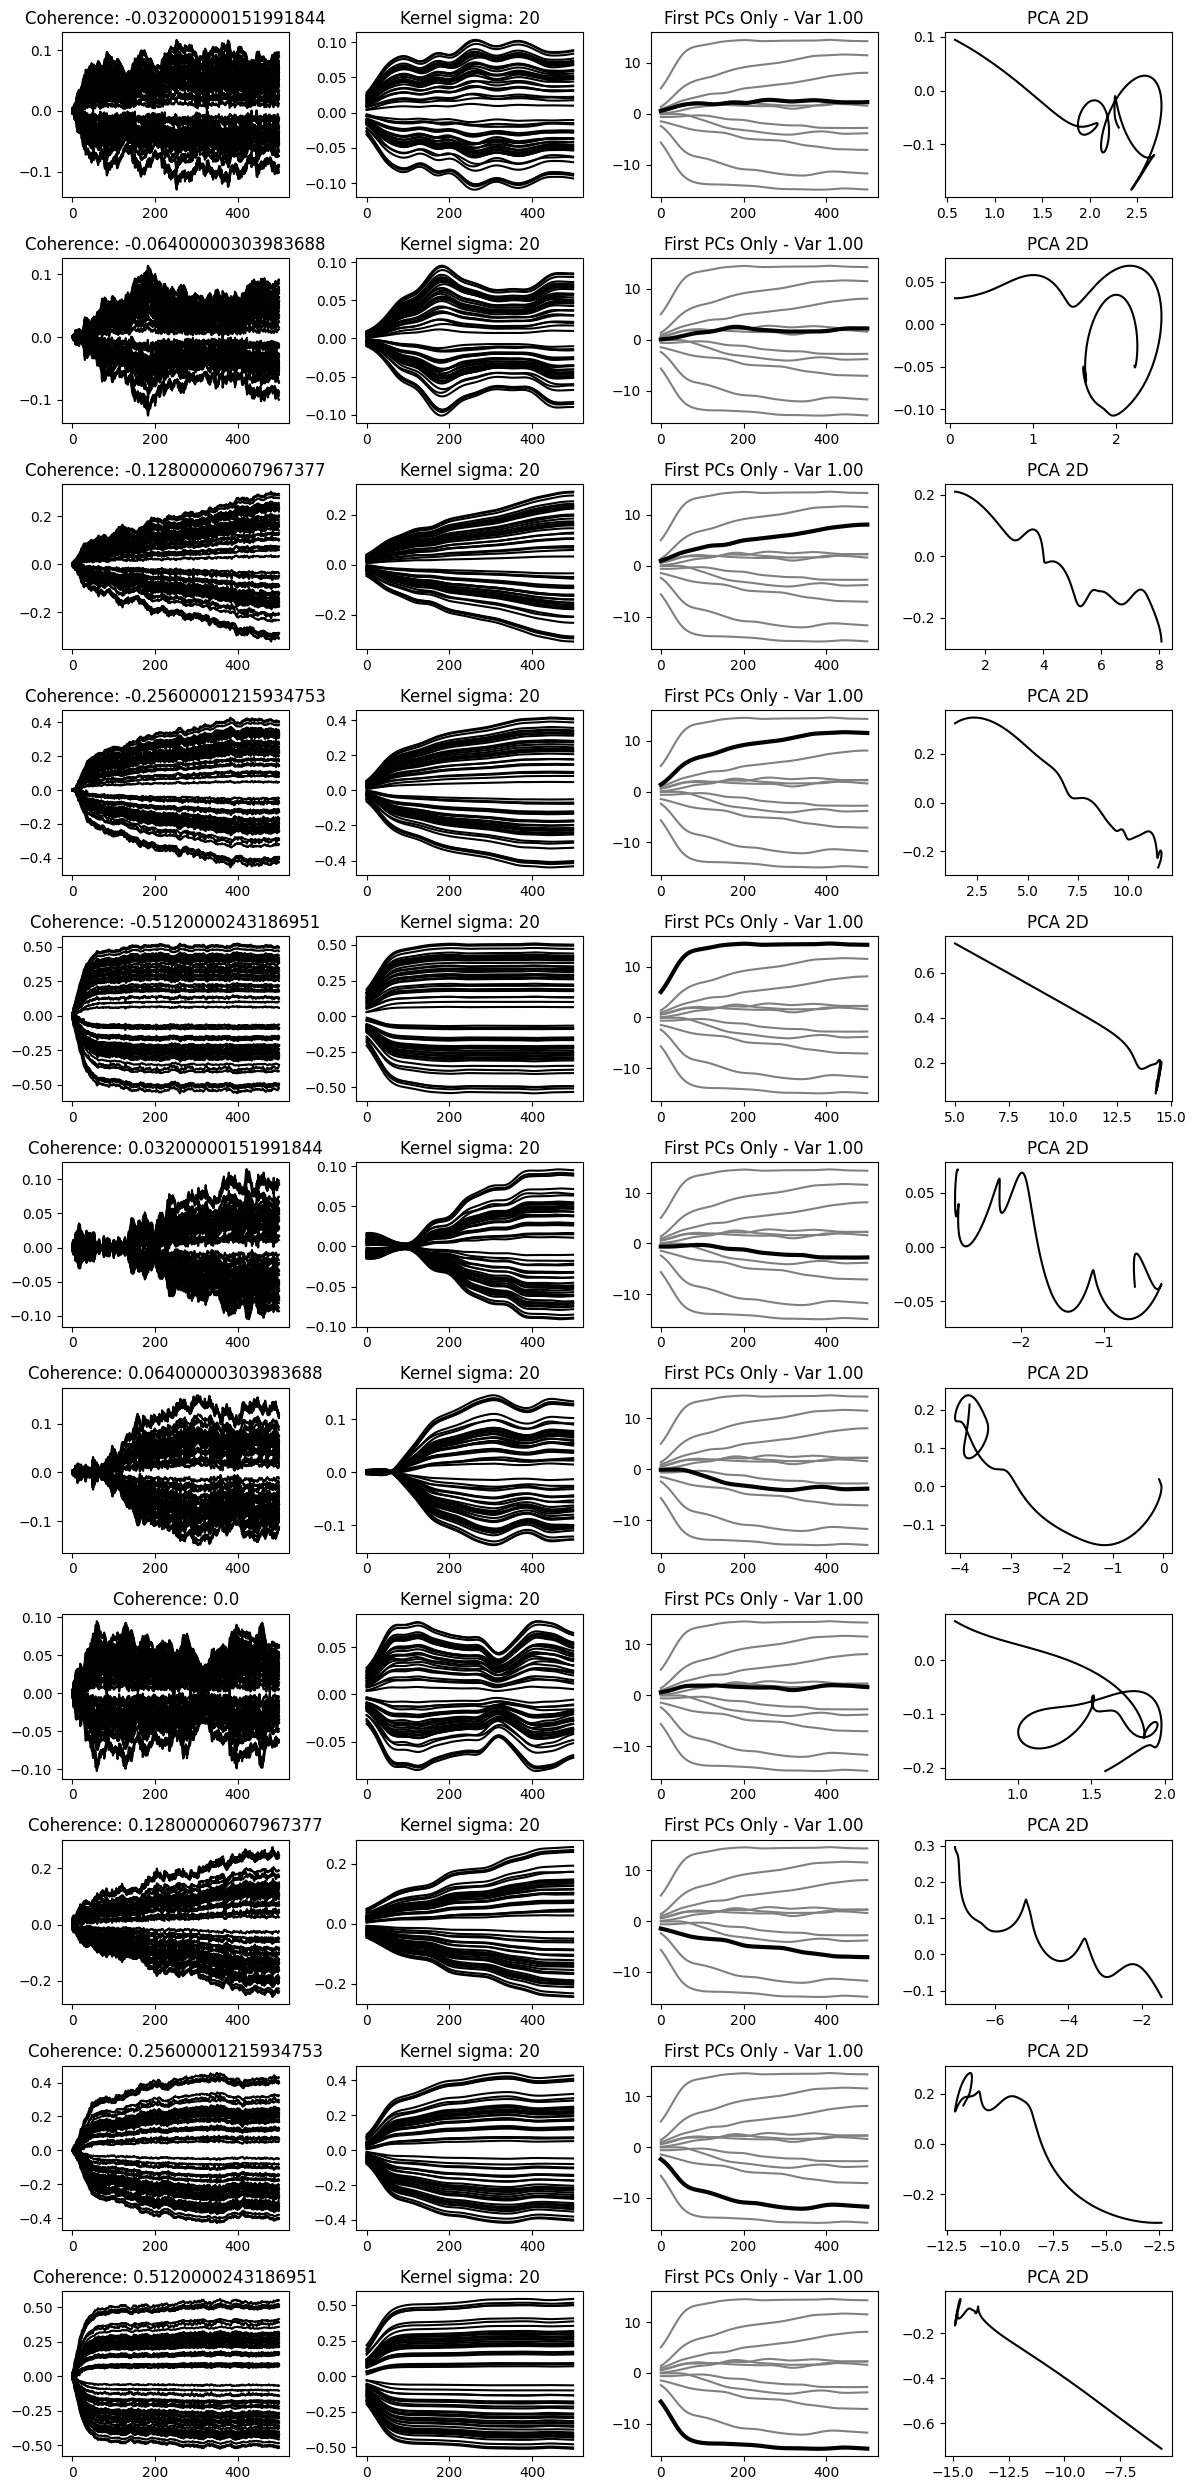

In [10]:
fig = plt.figure(figsize=(12, 25))
for i in range(psths.shape[0]):
    ax = plt.subplot(psths.shape[0], 4, i*4+1)
    ax.plot(psths[i,:,:], color='black')
    ax.set_title('Coherence: {}'.format(round(p2_coh_levels[i],3)))

    ax = plt.subplot(psths.shape[0], 4, i*4+2)
    ax.plot(psths_smooth[i,:,:], color='black')
    ax.set_title('Kernel sigma: {}'.format(sigma))
    
    ax = plt.subplot(psths.shape[0], 4, i*4+3)
    ax.plot(Y_pca_reshaped[:, :, 0].T, color='gray')
    ax.plot(Y_pca_reshaped[i, :, 0], color='black', lw=3)
    ax.set_title('First PCs Only - Var {:.2f}'.format(pca.explained_variance_ratio_[0]))

    ax = plt.subplot(psths.shape[0], 4, i*4+4)
    ax.plot(Y_pca_reshaped[i, :, 0], Y_pca_reshaped[i, :, 1], color='black')
    ax.set_title('PCA 2D')
    
fig.tight_layout()
plt.show()


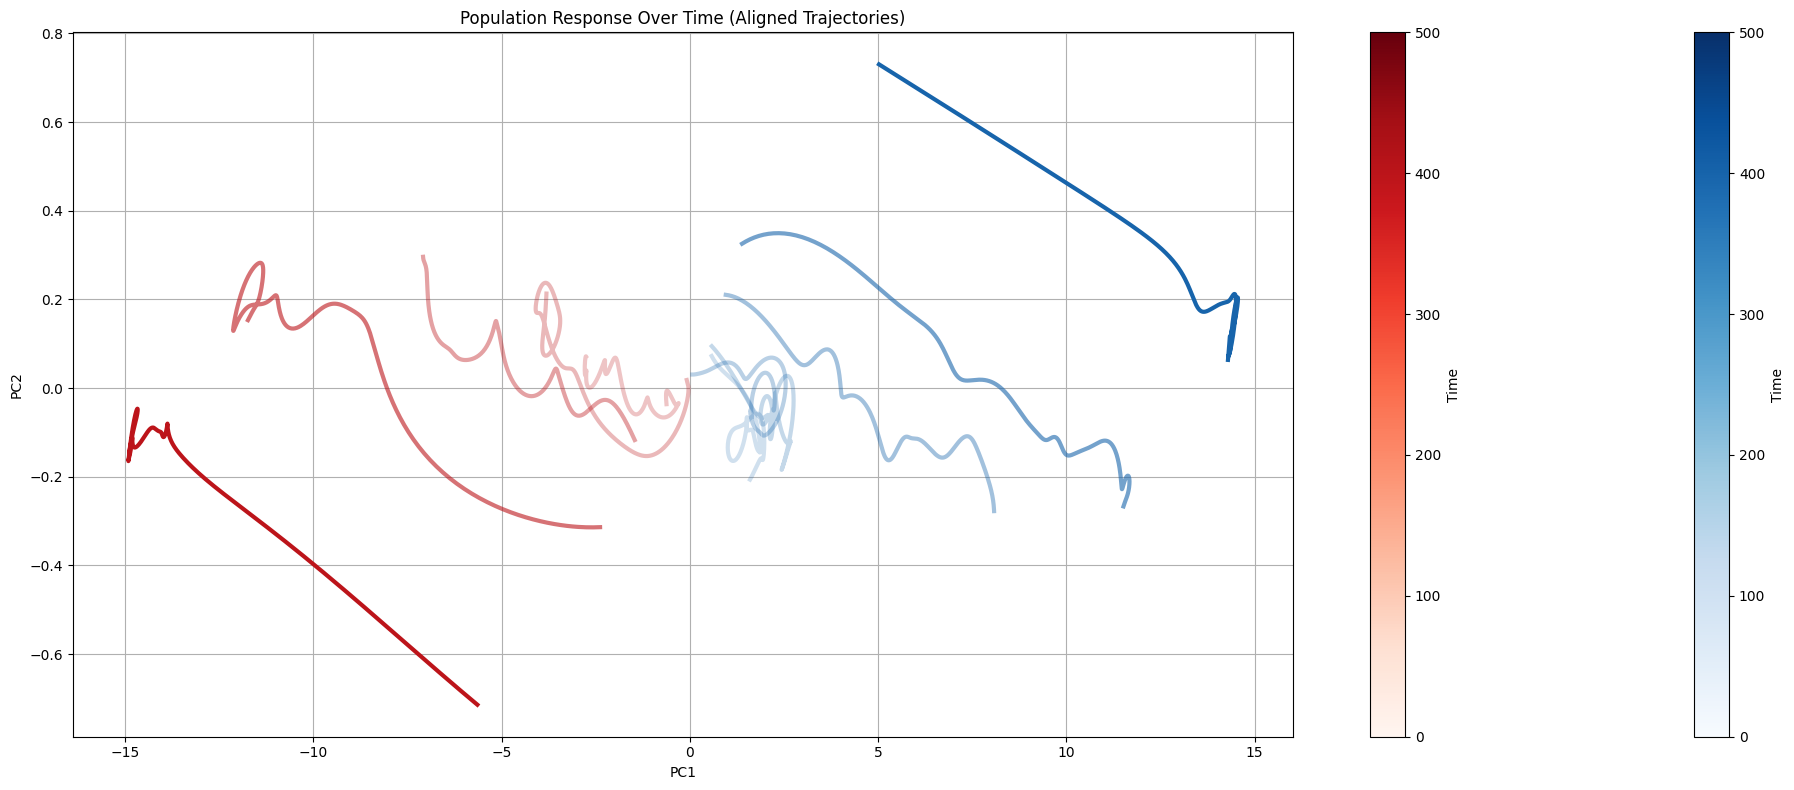

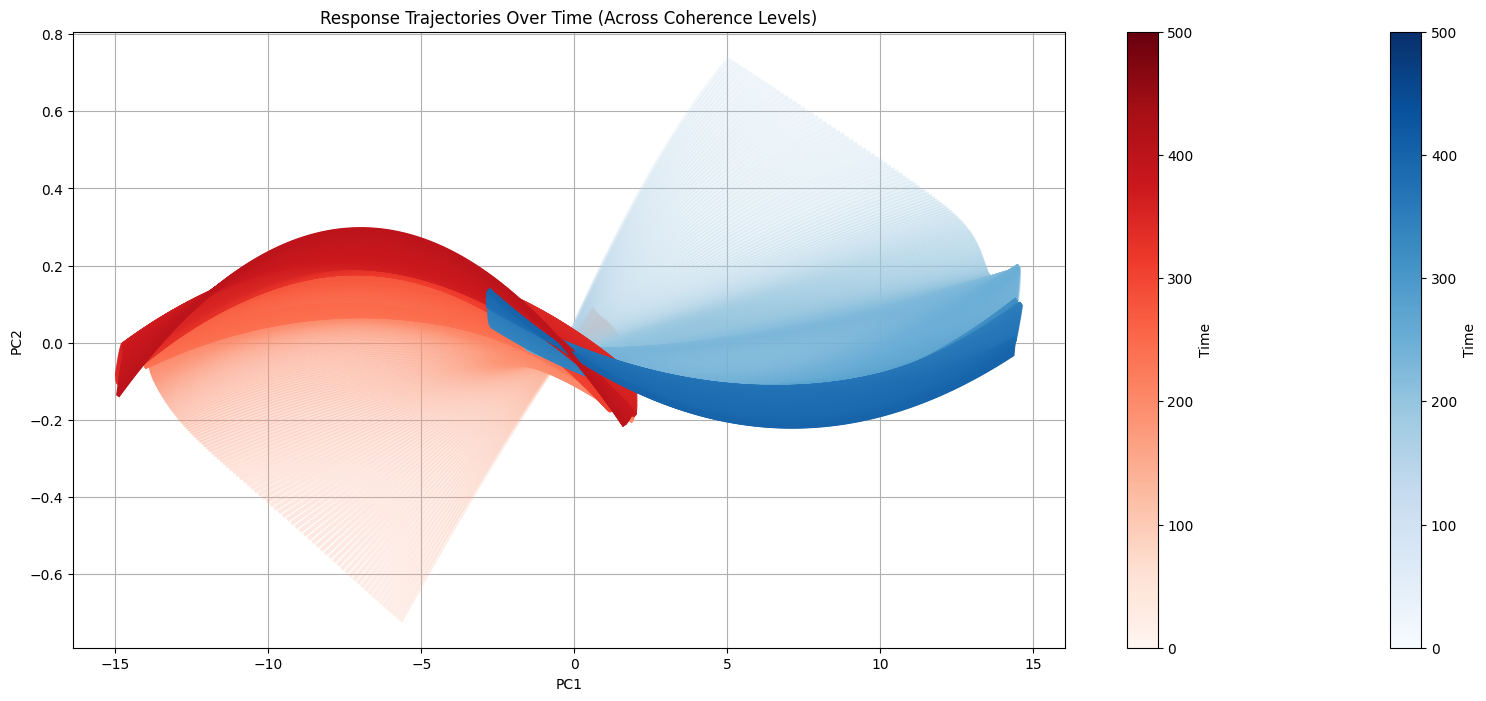

In [11]:
plot_pca(Y_pca_reshaped, p2_coh_levels)
plot_pca_time(Y_pca_reshaped, p2_coh_levels)

In [12]:
Y_pca_reshaped.shape

(11, 500, 2)

In [ ]:
stop()

NameError: name 'stop' is not defined

In [13]:
""" Project single-trial data into PCA space """

def project_single_trial(Y, pca):
    Y_transformed = []
    for i in range(Y.shape[0]):
        Y_transformed.append(pca.transform(Y[i,:,:]))
    Y_transformed = jnp.stack(Y_transformed, axis=0)
    return Y_transformed

Y_transformed = project_single_trial(Y[:,:,:], pca)
# Y_transformed = (Y_transformed - jnp.mean(Y_transformed, axis=0, keepdims=True)) / jnp.std(Y_transformed, axis=0, keepdims=True)
Y_transformed = (Y_transformed - jnp.mean(Y_transformed, axis=(0,1), keepdims=True)) / jnp.std(Y_transformed, axis=(0,1), keepdims=True)
print(Y_transformed.shape)

(1500, 500, 2)


In [14]:
# from sklearn.decomposition import PCA
# import numpy as np
# from scipy.ndimage import gaussian_filter1d

# def preprocess_for_pca_no_avg(Y, coherence_indices, boxcar_window=500):
#     all_trials = []
#     for idx in range(len(coherence_indices)):
#         if idx == len(coherence_indices) - 1:
#             trials = Y[coherence_indices[idx]:]
#         else:
#             trials = Y[coherence_indices[idx]:coherence_indices[idx + 1]]
        
#         # Smooth each trial independently
#         trials_smooth = [gaussian_filter1d(trial, sigma=10, axis=0, mode='nearest') for trial in trials]
#         trials_smooth = trials
#         # trials_smooth = (trials - jnp.mean(trials, axis=1, keepdims=True)) / jnp.std(trials, axis=1, keepdims=True)
#         all_trials.append(np.array(trials_smooth))

#     all_trials = np.concatenate(all_trials, axis=0)  # Combine all trials
#     mean_activity = np.mean(all_trials, axis=(0,1), keepdims=False)  # Mean across all trials
#     trials_detrended = all_trials - mean_activity  # Subtract the mean
#     # trials_detrended = all_trials
#     # trials_zscored = (trials_detrended - np.mean(trials_detrended, axis=(0, 1), keepdims=True)) / np.std(trials_detrended, axis=(0, 1), keepdims=True)
#     # trials_detrended = all_trials
#     n_trials, n_timepoints, n_neurons = trials_detrended.shape
#     Y_reshaped = trials_detrended.reshape(n_trials * n_timepoints, n_neurons)

#     return Y_reshaped, n_trials, n_timepoints

# def run_pca_no_avg(Y, coherence_indices):
#     Y_pca_input, n_trials, n_timepoints = preprocess_for_pca_no_avg(Y, coherence_indices)

#     pca = PCA(n_components=2)
#     Y_pca = pca.fit_transform(Y_pca_input)
#     Y_pca_reshaped = Y_pca.reshape(n_trials, n_timepoints, -1)

#     var_explained = pca.explained_variance_ratio_
#     print('Variance explained:', var_explained)

#     return Y_pca_reshaped

# Y_pca_reshaped = run_pca_no_avg(Y[:,:,:], coherence_indices)
# assert Y_pca_reshaped.shape == (Y.shape[0], Y.shape[1], 2)
Y = Y_transformed
Y = jnp.array(Y)
Y = (Y - jnp.mean(Y)) / jnp.std(Y)
unshuffled_Y = jnp.copy(Y)

In [15]:
# Y = (Y - jnp.mean(Y, axis=(0, 1), keepdims=True)) / jnp.std(Y, axis=(0, 1), keepdims=True)
# jnp.std(Y)

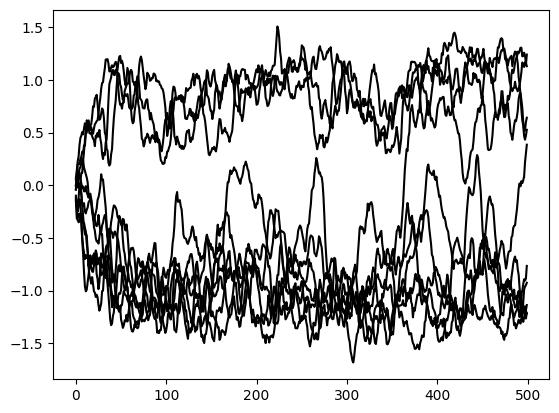

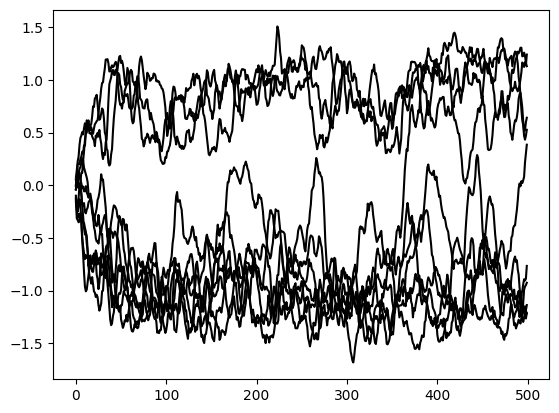

In [16]:
plt.plot(Y_transformed[:10, :, 0].T, color='black')
plt.show()
plt.plot(Y[:10, :, 0].T, color='black')
plt.show()

In [17]:
stop()

NameError: name 'stop' is not defined

In [18]:
T = int(500/bin_window)

U = jnp.stack((U1.squeeze(), U2), axis=-1)
preU = jnp.copy(U)  

print(U.shape)

M_conditions = U.shape[2]
B_batches = U.shape[0]

print("B_batches, T, N_neurons, M_conditions")
print(B_batches, T, Y.shape[-1], M_conditions)
print(U.shape, Y.shape)


# # test model works with small sample
N = 2
# N = 60
K = jxr.choice(jxr.PRNGKey(34), B_batches, (Y.shape[0],), replace=False) # 774
# K = valid_trials
# K = B_batches
T1 = 0
T2 = T 
T = T2 - T1
M = U.shape[-1]

xstar1 = jnp.zeros(U1.squeeze().shape).T
xstars = jnp.array([xstar1, xstar1]).T
print(xstars.shape)
# Y = jnp.nan_to_num(Y)
# U = jnp.nan_to_num(U)

Y = Y[K, T1:T2, :N]
U = U[K, T1:T2, :M]
xstars = xstars[K]

Y_mask = Y_mask[K, T1:T2]

print(U.shape, Y.shape)

partition = 0.8
n_trials = Y.shape[0]
n_train = int(n_trials * partition)
n_test = n_trials - n_train

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
perm = jax.random.permutation(subkey, n_trials)

Y = Y[perm]
U = U[perm]
xstars = xstars[perm]
Y_train = Y[:n_train]
U_train = U[:n_train]
xstars_train = xstars[:n_train]
Y_test = Y[n_train:]
U_test = U[n_train:]
xstars_test = xstars[n_train:]

Y_mask = Y_mask[perm]
Y_train_mask = Y_mask[:n_train]
Y_test_mask = Y_mask[n_train:]


(1500, 500, 2)
B_batches, T, N_neurons, M_conditions
1500 500 2 2
(1500, 500, 2) (1500, 500, 2)
(1500, 500, 2)
(1500, 500, 2) (1500, 500, 2)


In [19]:
print(jnp.std(Y))

1.0000001


coherencies
(11,)
t_period, c_period
3.098 3.124
(1200, 500, 2) (1200, 500, 2) (300, 500, 2) (300, 500, 2)


jit compiling ...:   0%|          | 0/1000 [00:00<?, ?it/s]2025-01-07 15:49:35.355615: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %divide.499 = f32[1200,500,2]{2,1,0} divide(f32[1200,500,2]{2,1,0} %constant.61, f32[1200,500,2]{2,1,0} %broadcast.498), metadata={op_name="jit(em_step)/jit(main)/div" source_file="/Users/andrewaoun/Documents/PHD/Projects/GPLDS/gplds/utils.py" source_line=309}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-01-07 15:49:35.363797: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.009227s
Constant folding an instruction 

Test log likelihood: 257742.34375


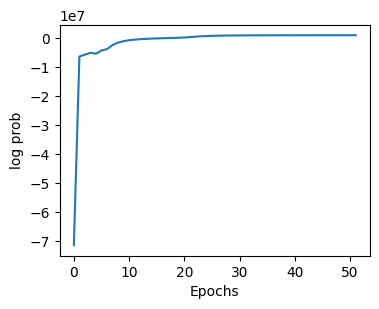

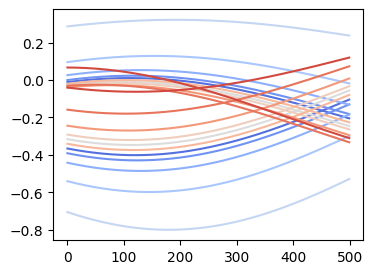

In [20]:
# coherencies = jnp.arange(-1, 1, 0.01)
coherencies = jnp.unique(U[:,:,0].squeeze())
latent_dim = 2
sigma = jnp.std(Y)
kappa = 0.35

t_range = jnp.unique(U2)

c_period = (coherencies.max() - coherencies.min()) + 6 * kappa # 2 + 6 * kappa
t_period = (t_range.max() - t_range.min()) + 6 * kappa # 2 + 6 * kappa

print("coherencies")
print(coherencies.shape)
print("t_period, c_period")
print(t_period, c_period)

torus_basis_funcs = utils.Tm_basis(latent_dim, M, sigma, kappa, period=jnp.array([c_period,t_period]))

A_prior = WeightSpaceGaussianProcess(torus_basis_funcs, D1=latent_dim, D2=latent_dim)
b_prior = WeightSpaceGaussianProcess(torus_basis_funcs, D1=latent_dim, D2=1)
m0_prior = WeightSpaceGaussianProcess(torus_basis_funcs, D1=latent_dim, D2=1)

print(Y_train.shape, U_train.shape, Y_test.shape, U_test.shape)

# Initialize
seed = 0
A_key, b_key, C_key, m0_key = jxr.split(jxr.PRNGKey(seed), 4)
initial_params = ParamswGPLDS(
    dynamics_gp_weights = A_prior.sample_weights(A_key),
    Q = jnp.eye(latent_dim)*0.01,
    R = jnp.eye(N)*0.01,
    m0 = jnp.zeros(latent_dim),
    S0 = jnp.eye(latent_dim),
    Cs = jnp.tile(jxr.normal(C_key, (N, latent_dim)), (T, 1, 1)), 
    # Cs = jxr.normal(C_key, (N, latent_dim)), 
    emissions_gp_weights = None,
    bs = jnp.zeros((T-1, latent_dim)),
    bias_gp_weights = b_prior.sample_weights(b_key),
    m0_gp_weights = m0_prior.sample_weights(m0_key),
)

# Instanciate model
model = wGPLDS(
    wgps={'A': A_prior, 'b': b_prior, 'C': None, 'm0': m0_prior,}, 
    state_dim=latent_dim, 
    emission_dim=N,
    # params= initial_params
    )


# Fit model
model_params, log_probs = fit_em(model=model, emissions=Y_train, conditions=U_train, num_iters=1000, params=initial_params, emissions_mask=Y_train_mask, xstars=xstars_train)
# log_probs = fit_em(model, Y_train, U_train, num_iters=50)
# model_params = model.params

# Evaluate
test_ll = model.marginal_log_lik(params=model_params, emissions=Y_test, conditions=U_test, emissions_mask=Y_test_mask, xstars=xstars_test)
# test_ll = model.marginal_log_lik(model_params, emissions=Y_train, conditions=U_train)
print(f"Test log likelihood: {test_ll}")

# Show results
fig, ax = plt.subplots(figsize=[4,3])
ax.plot(log_probs)
ax.set_ylabel('log prob')
ax.set_xlabel('Epochs')

fig, ax = plt.subplots(ncols=1, figsize=[4,3])
coh_colors = sns.color_palette('coolwarm', len(coherence_indices))
ct = 0
for i in coherence_indices:
    ax.plot(A_prior.sample(jxr.PRNGKey(0), preU[i])[:,0,0], c=coh_colors[ct])
    ax.plot(A_prior.sample(jxr.PRNGKey(0), preU[i])[:,0,1], c=coh_colors[ct])
    ct += 1

In [21]:
print(Y_train_mask.shape, U_train.shape, Y_train.shape, xstars_train.shape)
print(Y_test_mask.shape, U_test.shape, Y_test.shape, xstars_test.shape)

(1200, 500) (1200, 500, 2) (1200, 500, 2) (1200, 500, 2)
(300, 500) (300, 500, 2) (300, 500, 2) (300, 500, 2)


Text(0.5, 0.98, 'Dynamics matrix $A$')

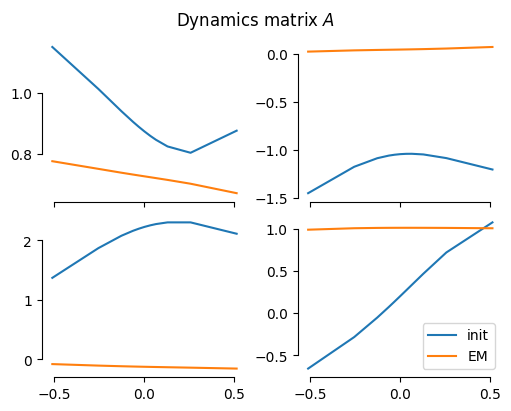

In [22]:

fig, axs = plt.subplots(ncols=latent_dim, nrows=latent_dim, figsize=(5, 4), constrained_layout=True)

# touse = jnp.arange(-1,1,0.01)
touse = coherencies

for i in range(latent_dim):
    for j in range(latent_dim):
        ax = axs[i,j]
        ax.plot(touse, A_prior(initial_params.dynamics_gp_weights, touse[:])[:,i,j], label='init')
        ax.plot(touse, A_prior(model_params.dynamics_gp_weights, touse[:])[:,i,j], label='EM')
        # ax.set_title(f'A[{i},{j}]')
axs[1,1].legend()

for ax in axs.flatten():
    sns.despine(ax=ax, trim=True, offset=True)
for ax in axs[0]:
    ax.set_xticklabels([])
    
fig.suptitle('Dynamics matrix $A$')

Text(0.5, 0, 'Time')

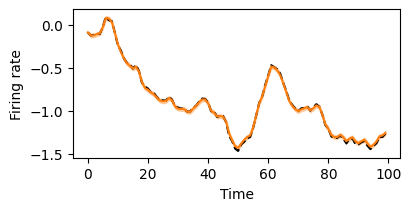

In [23]:

_, (filtered_means, _), (smoothed_means, smoothed_covs, _) = model.smoother(
    model_params, 
    emissions = Y_test[0],
    inputs = U_test[0],
    emissions_mask = Y_test_mask[0],
    xstar = xstars_test[0],
)

reconstructed_ys = jnp.einsum('nl,tl->tn', model_params.Cs, smoothed_means)
reconstructed_ys_covs = jnp.einsum('nl,tlk,mk->tnm', model_params.Cs, smoothed_covs, model_params.Cs)
n_neurons = Y_test[0].shape[-1]
fig, ax = plt.subplots(figsize=[4,2], constrained_layout=True)
for neuron_id in range(n_neurons)[::2]:
    ax.plot(Y_test[0][:100,neuron_id] , c='k', ls='--')
    ax.plot(reconstructed_ys[:100,neuron_id], c='tab:orange')
    ax.fill_between(
        jnp.arange(len(reconstructed_ys))[:100],
        reconstructed_ys[:100,neuron_id] - 2 * jnp.sqrt(reconstructed_ys_covs[:100,neuron_id,neuron_id]),
        reconstructed_ys[:100,neuron_id] + 2 * jnp.sqrt(reconstructed_ys_covs[:100,neuron_id,neuron_id]),
        alpha=0.3, color='tab:orange',
    )
ax.set_ylabel('Firing rate')
ax.set_xlabel('Time')
# plt.legend()
# ax.set_title('Reconstructed data, half the neurons')
# plt.savefig('figures/HD_reconstructed_data.eps')

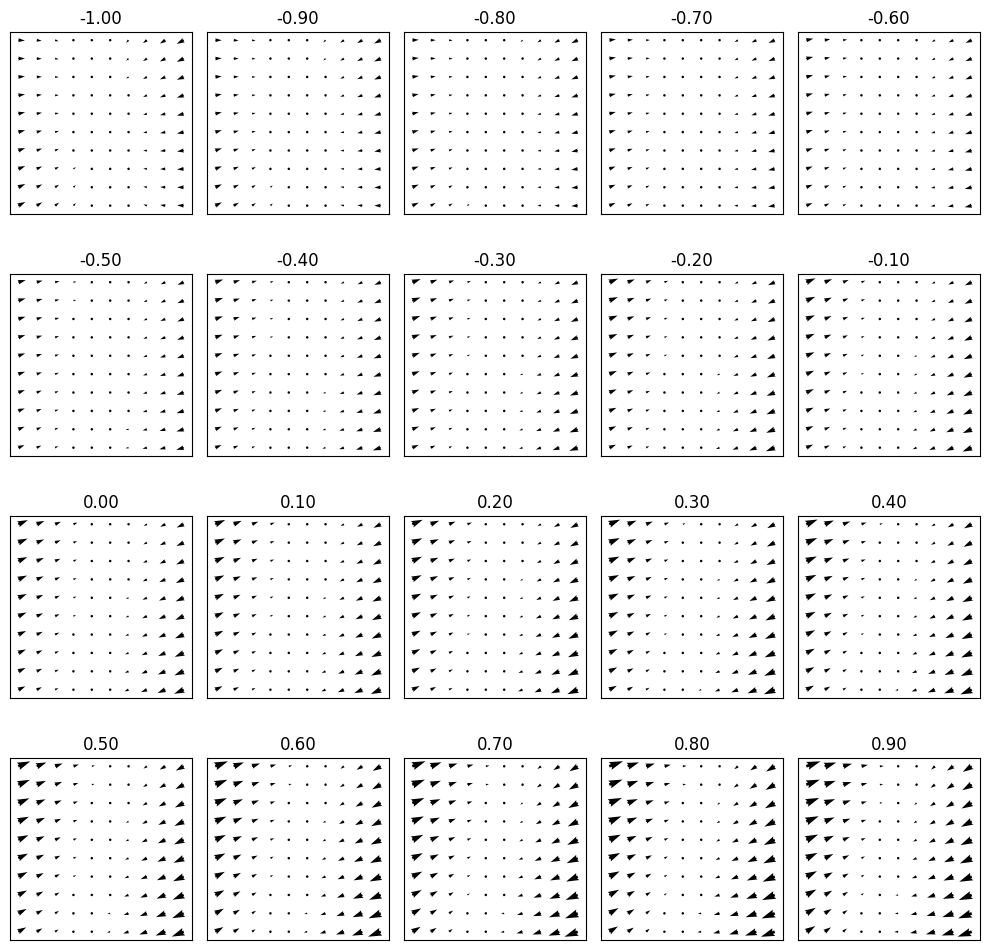

In [24]:
# Plot vector field given 2x2 matrix

def plot_vector_field(A, ax, color='k'):
    x = jnp.linspace(-1, 1, 10)
    y = jnp.linspace(-1, 1, 10)
    X, Y = jnp.meshgrid(x, y)
    U = A[0, 0] * X + A[0, 1] * Y
    V = A[1, 0] * X + A[1, 1] * Y

    # Thicken the arrows
    ax.quiver(X, Y, U, V, units='width', scale=6, width=0.015, color=color)

_As = A_prior(model_params.dynamics_gp_weights, jnp.arange(-1,1,0.1))

# _U, _S, _ = jnp.linalg.svd(model_params.Q)
# H = jnp.linalg.pinv(jnp.diag(jnp.sqrt(_S))) @ _U.T
# Hinv = _U @ jnp.diag(jnp.sqrt(_S))

# _As = jnp.einsum('ij,tjk,kl->til', H, _As, Hinv)

fig = plt.figure(figsize=(10, 10))
c = 1
for i in range(4):
    for j in range(5):
        ax = plt.subplot(4, 5, c)
        plot_vector_field(_As[c-1]-jnp.eye(_As.shape[-1]), ax)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'{jnp.arange(-1,1,0.1)[c-1]:.2f}')
        c += 1
fig.tight_layout()
plt.show()


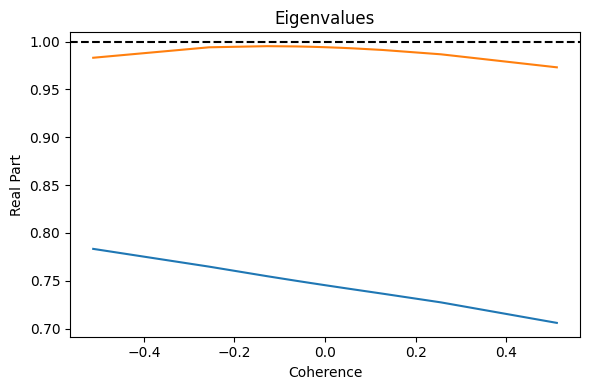

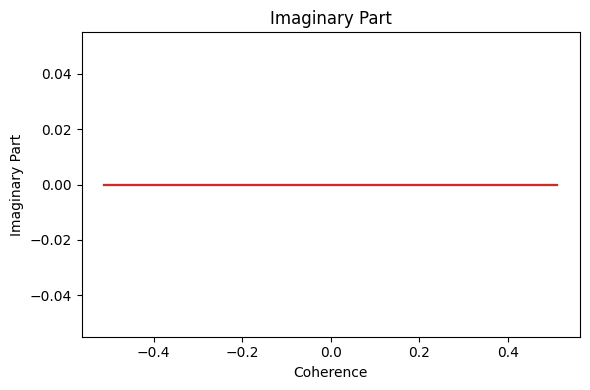

In [25]:
bs_theta = b_prior(model_params.bias_gp_weights, touse).squeeze()
As_theta = A_prior(model_params.dynamics_gp_weights, touse)

eigvals, eigvecs = jnp.linalg.eig(As_theta)

fig, ax = plt.subplots(figsize=[6, 4])
for i in range(eigvals.shape[1]): 
    ax.plot(touse, eigvals.real[:, i])
ax.axhline(1, c='k', ls='--')
ax.set_title('Eigenvalues')
ax.set_xlabel('Coherence')
ax.set_ylabel('Real Part')
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=[6, 4])
for i in range(eigvecs.shape[1]): 
    ax.plot(touse, eigvecs.imag[:, i])
ax.set_title('Imaginary Part')
ax.set_xlabel('Coherence')
ax.set_ylabel('Imaginary Part')
fig.tight_layout()
plt.show()



Text(0.5, 0.98, 'Top eigenvalue of $A(\\cdot)$ as function of time and coherence')

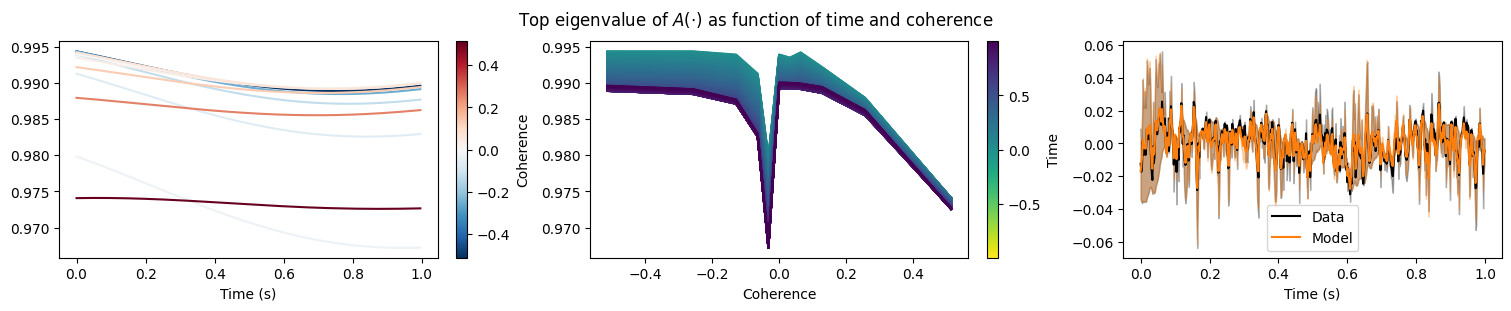

In [26]:
import matplotlib

coherencies = jnp.unique(U1)
t_range = jnp.unique(U2)

params = model_params
# coherencies = jnp.hstack([jnp.sort(-coh[1:]), jnp.sort(coh)]) # "1:" to remove 0 at first index
# coherencies = jnp.arange(-1, 1, 0.01)
eigenvals = []
for i in range(len(coherence_indices)):
    As = A_prior(params.dynamics_gp_weights, preU[coherence_indices[i],:,:])
    # As = A_prior(params.dynamics_gp_weights, jnp.stack((U1, U3), axis=-1)[coherence_indices[i]])
    vals = jnp.array([jnp.sort(jnp.linalg.eigvals(As[t]).real)[-1] for t in range(len(t_range)-1)])
    # vals = jnp.array([jnp.linalg.det(As[t]) for t in range(len(t_range)-1)])
    # vals = jnp.array([nonnormality_metric(As[t]) for t in range(len(t_range)-1)])
    eigenvals.append(vals)

eigenvals = jnp.stack(eigenvals)

c_sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=min(coherencies), vmax=max(coherencies)))
c_colors = c_sm.to_rgba(coherencies)
t_sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=matplotlib.colors.CenteredNorm(vcenter=0.))
t_colors = t_sm.to_rgba(t_range[:-1])

fig, axs = plt.subplots(ncols=3, figsize=[15,3], constrained_layout=True)
for i in range(len(coherencies)):
    axs[0].plot(t_range[:-1], eigenvals[i], color=c_colors[i])
# axs[0].axhline(1.0, color='k', linestyle='--', zorder=-1)
axs[0].set_xlabel(f'Time (s)')
fig.colorbar(c_sm, ax=axs[0], orientation='vertical', label='Coherence')

for i in range(len(t_range)-1)[::2]:
    axs[1].plot(coherencies, eigenvals[:,i], color=t_colors[i])
    
# axs[1].plot(coherencies, eigenvals[:,15], alpha=0.5)
# axs[1].plot(coherencies, eigenvals[:,-1], alpha=0.5)
# axs[1].axhline(1.0, color='k', linestyle='--', zorder=-1)
axs[1].set_xlabel('Coherence')
axs[1].sharey(axs[0])

# reconstruct_y = lambda b: jnp.einsum('tnl,tl->tn', params.Cs, model.smoother(params, Y[b], U[b])[2][0])
reconstruct_y = lambda b: jnp.einsum('nl,tl->tn', params.Cs, model.smoother(params, Y[b], U[b], Y_mask[b], xstars[b])[2][0])

reconstructed_ys = jax.vmap(reconstruct_y)(jnp.arange(len(Y)))
# reconstructed_ys = []
# for b in range(len(Y)):
#     print(params.Cs[:30,:].shape, model.smoother(params, Y[b], U[b])[2][0].shape)
    
#     reconstructed_y = jnp.einsum('tnl,tl->tn', jnp.rep
#                                  , model.smoother(params, Y[b], U[b])[2][0])
#     reconstructed_ys.append(reconstructed_y)

_y_perneuron = reconstructed_ys.mean(0)
axs[2].plot(t_range, Y.mean(0).mean(1), c='k', label='Data')
axs[2].fill_between(
    t_range, 
    Y.mean(0).mean(1) - Y.mean(0).std(1), 
    Y.mean(0).mean(1) + Y.mean(0).std(1), 
    color='k', alpha=0.3
)

axs[2].plot(t_range, _y_perneuron.mean(1), c='tab:orange', label='Model')
axs[2].fill_between(
    t_range, 
    _y_perneuron.mean(1) - _y_perneuron.std(1), 
    _y_perneuron.mean(1) + _y_perneuron.std(1), 
    color='tab:orange', alpha=0.3
)

axs[2].set_xlabel('Time (s)')
axs[2].legend()

fig.colorbar(t_sm, ax=axs[1], orientation='vertical', label='Time')
fig.suptitle('Top eigenvalue of $A(\cdot)$ as function of time and coherence')

In [27]:
import postprocessing
fixed_points = postprocessing.get_fixed_points(model, model_params, touse, ROTATE=False)
# fixed_points = fixed_points[:,:2]

In [28]:
# fixed_points_coherence = postprocessing.get_fixed_points_by_coherence(model, model_params, coherence_groups, ROTATE=False)

In [29]:
_U, _S, _ = jnp.linalg.svd(params.Q)
H = jnp.linalg.pinv(jnp.diag(jnp.sqrt(_S))) @ _U.T
Hinv = _U @ jnp.diag(jnp.sqrt(_S))

bs_theta_rot = jnp.einsum('ij,tj->ti', H, bs_theta)
As_theta_rot = jnp.einsum('ij,tjk,kl->til', H, As_theta, Hinv)

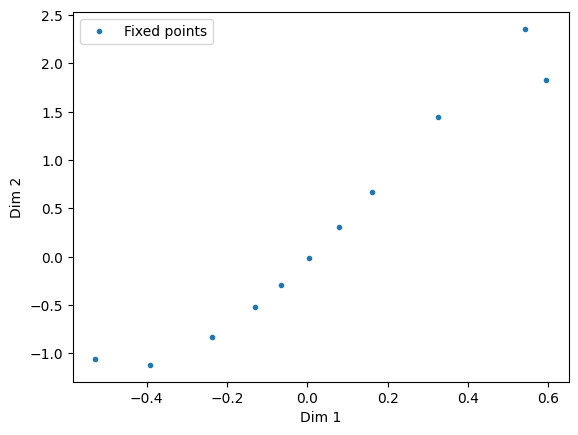

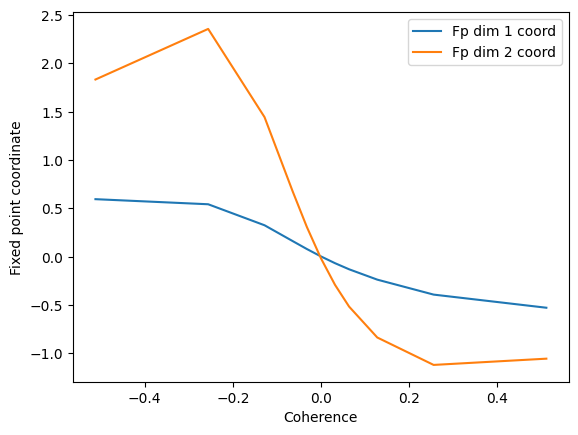

In [30]:
plt.plot(*fixed_points[:,:].T, '.', label='Fixed points')
# plt.plot(*bs_theta_rot.T, '.', label='Bias')
plt.legend()
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.show()

plt.plot(touse, fixed_points[:,0], label='Fp dim 1 coord')
plt.plot(touse, fixed_points[:,1], label='Fp dim 2 coord')
plt.xlabel('Coherence')
plt.ylabel('Fixed point coordinate')
plt.legend()
plt.show()

In [31]:
# Compute smoothed latents for all trials
latents = []
for b in range(len(unshuffled_Y)): 
    """" MAKE SURE UNSHUFFLED Y IS NOT FROM BEFORE YOU TAKE A SAMPLE (i.e. MAKE SURE IT ONLY HAS TRIALS YOU INCLUDE IN TRAINT/TEST SPLIT)"""
    # Run the smoother on each trial
    _, (_, _), (smoothed_means, smoothed_covs, _) = model.smoother(
        model_params, 
        emissions=unshuffled_Y[b], 
        inputs=preU[b], 
        emissions_mask=Y_mask[b],
        xstar=xstars[b]
    )

    # # rotate the latents
    # _U, _S, _ = jnp.linalg.svd(model_params.Q)
    # H = jnp.linalg.pinv(jnp.diag(jnp.sqrt(_S))) @ _U.T
    # Hinv = _U @ jnp.diag(jnp.sqrt(_S))
    # smoothed_means = jnp.einsum('ij,tj->ti', H, smoothed_means.squeeze())

    latents.append(smoothed_means)

latents = jnp.array(latents)  # shape: (n_trials, T, latent_dim)
print("Latent trajectories shape:", latents.shape)

Latent trajectories shape: (1500, 500, 2)


In [32]:
# # gaussian filter and detrend the fixed points like the latents
# # fixed_points_smoothed = gaussian_filter1d(fixed_points, sigma=10, axis=0, mode='nearest')
# # fixed_points_smoothed = fixed_points_smoothed - jnp.mean(fixed_points_smoothed, axis=0, keepdims=True)

fixed_points_smoothed = gaussian_smooth_truncated(fixed_points, sigma=20).T
fixed_points_smoothed = (fixed_points_smoothed - jnp.mean(fixed_points_smoothed, axis=0, keepdims=True)) / jnp.std(fixed_points_smoothed, axis=0, keepdims=True)
# fixed_points_smoothed = fixed_points
print(fixed_points_smoothed.shape)

(11, 2)


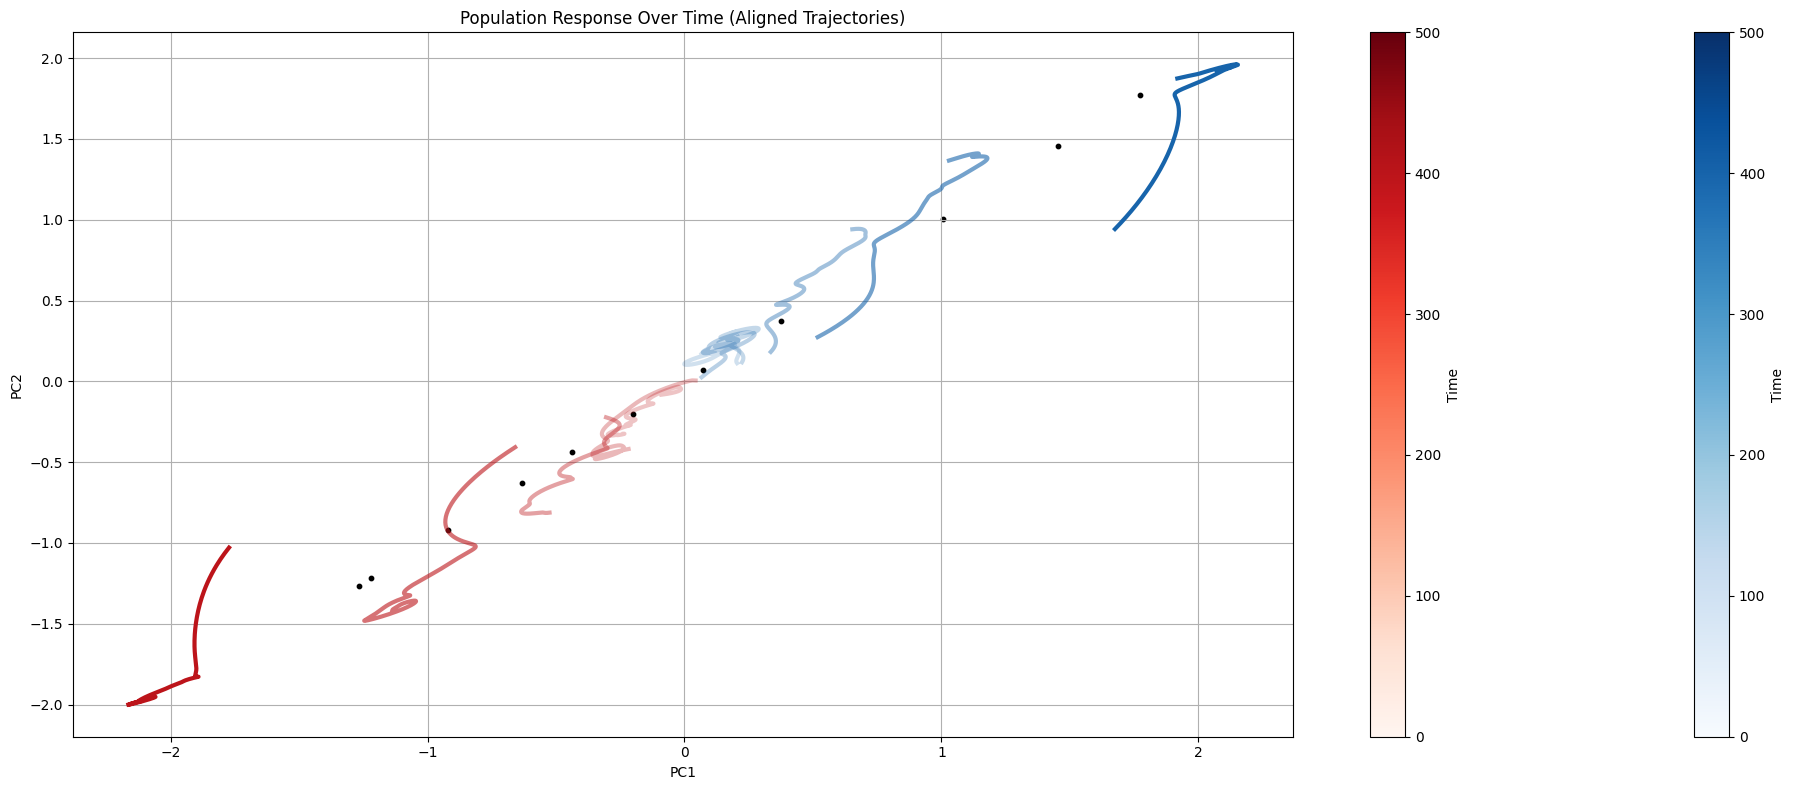

In [33]:
def preprocess(Y, coherence_indices, sigma=20):
    psths = []
    for idx in range(len(coherence_indices)):
        if idx == len(coherence_indices) - 1:
            trials = Y[coherence_indices[idx]:]
        else:
            trials = Y[coherence_indices[idx]:coherence_indices[idx + 1]]
        psth = jnp.mean(trials, axis=0)
        psths.append(psth)
    psths = jnp.array(psths)
    n_conditions, n_timepoints, n_neurons = psths.shape
    psths_smooth = jnp.array([gaussian_smooth_truncated(psths[:,:,i], sigma) for i in range(n_neurons)]).T
    psths_concat = jnp.concatenate(psths_smooth, axis=0)
    psths_zscored = (psths_concat - jnp.mean(psths_concat, axis=0, keepdims=True)) / jnp.std(psths_concat, axis=0, keepdims=True)
    return psths_zscored, n_conditions, n_timepoints, psths, psths_smooth, sigma

def plot_pca(Y_pca_reshaped, coherence_levels):
    plt.figure(figsize=(20, 8))
    ax = plt.subplot(111)

    max_abs_coh = max(abs(jnp.array(coherence_levels)))
    for idx in range(Y_pca_reshaped.shape[0]):
        if float(coherence_levels[idx]) <= 0:
            colors = plt.cm.Blues(jnp.linspace(0.3, 0.8, Y_pca_reshaped.shape[1]))
            shape = 'o'
            alpha = 0.2 + 0.8 * (abs(float(coherence_levels[idx].item())) / max_abs_coh)
        else:
            colors = plt.cm.Reds(jnp.linspace(0.3, 0.8, Y_pca_reshaped.shape[1]))
            shape = 'o'
            alpha = 0.2 + 0.8 * (abs(float(coherence_levels[idx].item())) / max_abs_coh)

        # for t in range(Y_pca_reshaped.shape[1]):
        #     ax.scatter(Y_pca_reshaped[idx, t, 0], Y_pca_reshaped[idx, t, 1],
        #                color=colors[t], marker=shape, edgecolor='k', alpha=alpha) # s=40 + t * 5)

        ax.plot(Y_pca_reshaped[idx, :, 0], Y_pca_reshaped[idx, :, 1],
                color=colors[-1], lw=3, alpha=alpha.item())
    # plot fixed points
    ax.scatter(fixed_points_smoothed[:,0], fixed_points_smoothed[:,1], s=10, c='k', label='Fixed points')
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=Y_pca_reshaped.shape[1]))
    sm.set_array([])
    plt.colorbar(sm, label='Time', ax=ax)
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=Y_pca_reshaped.shape[1]))
    sm.set_array([])
    plt.colorbar(sm, label='Time', ax=ax)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title('Population Response Over Time (Aligned Trajectories)')
    ax.grid(True)
    plt.tight_layout()
    plt.show()


def sort_coherence(Y_pca_reshaped, coherence_levels):
    coherence_levels = jnp.sort(coherence_levels)
    coh_neg = {str(coh) : [] for coh in coherence_levels if float(coh) <= 0}
    coh_pos = {str(coh) : [] for coh in coherence_levels if float(coh) > 0}
    for idx in range(Y_pca_reshaped.shape[0]):
        if float(coherence_levels[idx]) <= 0:
            coh_neg[str(coherence_levels[idx])] = Y_pca_reshaped[idx]
        if float(coherence_levels[idx]) > 0:
            coh_pos[str(coherence_levels[idx])] = Y_pca_reshaped[idx]
    return coh_neg, coh_pos

# now we plot PCA trajectories across all coherence levels for different time points
def plot_pca_time(Y_pca_reshaped, coherence_levels):
    coh_neg, coh_pos = sort_coherence(Y_pca_reshaped, coherence_levels)

    plt.figure(figsize=(20,8)) 
    # ax = plt.axes(projection='3d')
    ax = plt.subplot(111)

    

    for idx in range(Y_pca_reshaped.shape[1]):
    # for idx in range(0,10,1):
        colors = plt.cm.Blues(jnp.linspace(0.3, 0.8, Y_pca_reshaped.shape[1]))
        alpha = 0.2 + 0.8 * (idx / Y_pca_reshaped.shape[1])
        trial_cohs = []
        for coh in coh_neg:
            trial_cohs.append(coh_neg[coh][idx])
        trial_cohs = jnp.array(trial_cohs) 
        x = trial_cohs[:, 0]  
        y = trial_cohs[:, 1]
        # fit a curve not a line
        curve = jnp.polyfit(x, y, 2)
        x_fit = jnp.linspace(jnp.min(x), jnp.max(x), 100)
        y_fit = jnp.polyval(curve, x_fit)
        # ax.scatter(x, y, c='b', alpha=0.)
        ax.plot(x_fit, y_fit, c=colors[idx], alpha=alpha, lw=3)
        # ax.plot(x, y, c='b', alpha=idx / Y_pca_reshaped.shape[1], lw=3)
        
        colors = plt.cm.Reds(jnp.linspace(0.3, 0.8, Y_pca_reshaped.shape[1]))
        alpha = 0.2 + 0.8 * (idx / Y_pca_reshaped.shape[1])
        trial_cohs = []
        for coh in coh_pos:
            trial_cohs.append(coh_pos[coh][idx])
        trial_cohs = jnp.array(trial_cohs)
        x = trial_cohs[:, 0]
        y = trial_cohs[:, 1]
        # fit a curve not a line
        curve = jnp.polyfit(x, y, 2)
        x_fit = jnp.linspace(jnp.min(x), jnp.max(x), 100)
        y_fit = jnp.polyval(curve, x_fit)
        # ax.scatter(x, y, c='r', alpha=0.)
        ax.plot(x_fit, y_fit, c=colors[idx], alpha=alpha, lw=3)
        # ax.plot(x, y, c='r', alpha=idx / Y_pca_reshaped.shape[1], lw=3)
    # plot fixed points
    ax.scatter(fixed_points_smoothed[:,0], fixed_points_smoothed[:,1], s=10, c='k', label='Fixed points')
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=Y_pca_reshaped.shape[1]))
    sm.set_array([])
    plt.colorbar(sm, label='Time', ax=ax)
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=Y_pca_reshaped.shape[1]))
    sm.set_array([])
    plt.colorbar(sm, label='Time', ax=ax)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.grid(True)
    ax.set_title('Response Trajectories Over Time (Across Coherence Levels)')
    fig.tight_layout()
    plt.show()

psths_zscored, n_conditions, n_timepoints, psths, psths_smooth, sigma = preprocess(latents, coherence_indices, sigma=20)
psths_zscored = psths_zscored.reshape(n_conditions, n_timepoints, -1)
plot_pca(psths_zscored, p2_coh_levels)
# plot_pca_time(psths_zscored, p2_coh_levels)
# stop()

In [34]:
psths_zscored.shape

(11, 500, 2)

In [35]:
# # Plot vector fields per fixed point

# cmap = plt.cm.viridis
# theta_range = touse
# colors = cmap(theta_range/(2))

# # =============================================================================

# x_lims = (jnp.amin(fixed_points[:,0])-4, jnp.amax(fixed_points[:,0])+4)
# y_lims = (jnp.amin(fixed_points[:,1])-4, jnp.amax(fixed_points[:,1])+4)

# def plot_vector_field(A, ax, center=jnp.zeros((2,)), color='k'):
#     x = jnp.linspace(*x_lims, 8)
#     y = jnp.linspace(*y_lims, 8)
#     X, Y = jnp.meshgrid(x, y)
#     U = A[0, 0] * (X - center[0]) + A[0, 1] * (Y - center[1])
#     V = A[1, 0] * (X - center[0]) + A[1, 1] * (Y - center[1])

#     # Thicken the arrows
#     ax.quiver(X, Y, U, V, units='width', scale=70, width=0.02, color=color)
    

# # sns.set_style('white')
# fig = plt.figure(figsize=[10,3.5], constrained_layout=True)

# ncols = 5
# gs = fig.add_gridspec(1, ncols, wspace=0.1)
# axs = [fig.add_subplot(gs[0, i]) for i in range(ncols)]

# # indices = jnp.linspace(0, len(fixed_points), len(axs), endpoint=False, dtype=int)
# indices = [0,50,100,150,199]
# for i, ax in zip(indices, axs):
#     ax.scatter(*fixed_points[i], color=colors[i], edgecolors='k')
#     ax.plot(*fixed_points.T, c='k', alpha=0.2, zorder=-1)
#     plot_vector_field(As_theta_rot[i] - jnp.eye(As_theta_rot.shape[-1]), ax=ax, center=fixed_points[i], color=colors[i])
#     ax.set_title(f'$\\theta = {theta_range[i]:.2f}$')

# for ax in axs:
#     if ax is not axs[0]:
#         ax.set_yticklabels([])
#     ax.set_xlim(*x_lims)
#     ax.set_ylim(*y_lims)

# # Add colorbar
# norm = plt.Normalize(-1, 1)
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# fig.colorbar(sm, ax=axs, orientation='horizontal', label=r'$\theta$', aspect=50) # shrink=1.0

# fig.suptitle('Dynamics around fixed points')
# plt.show()

# # =============================================================================

# fig, ax = plt.subplots(figsize=[3,3])
# for i, fp in enumerate(fixed_points):
#     ax.scatter(*fp, color=colors[i])
# ax.set_title('Fixed points')
# plt.show()